"""
==============================================================================
02 - BASELINE XGBOOST MODEL
==============================================================================

PURPOSE OF THIS NOTEBOOK:
-------------------------
Train and evaluate the XGBoost baseline model for price direction prediction.

XGBoost is our BASELINE because:
1. It's a proven algorithm for tabular data (features in columns)
2. Fast training with GPU support
3. Handles missing values automatically
4. Provides feature importance (interpretability)
5. Works well out-of-the-box with minimal tuning


------------------
- How to prepare data for ML training
- Walk-forward cross-validation (crucial for time series!)
- Hyperparameter tuning with RandomizedSearchCV
- How to interpret feature importance
- Proper evaluation with confusion matrix

EXPECTED RESULTS:
-----------------
For 3-class classification (UP/SIDEWAYS/DOWN):
- Random baseline: ~33% accuracy
- Our goal: >40% accuracy and F1 > 0.35
- Any improvement over random is valuable for trading

"""

# XGBoost Baseline Model

**Goal**: Train a baseline classifier that beats random guessing (33%).

**Why XGBoost?**
- Best algorithm for tabular data
- GPU acceleration for fast training
- Interpretable feature importance

In [2]:
# ==============================================================================
# IMPORTS AND SETUP
# ==============================================================================
# 


import sys
from pathlib import Path

# Add project root to path for importing our modules
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

In [3]:
# ==============================================================================
# IMPORT PROJECT MODULES
# ==============================================================================
#
# Our custom modules:
# - load_and_merge_data: Combines klines, funding, volume data
# - split_data_by_time: Time-based train/val/test split (NOT random!)
# - create_oracle_labels: Generates UP/DOWN/SIDEWAYS targets
# - prepare_features: Adds 60+ technical indicators
# - get_indicator_columns: Filters feature column names
# - XGBBaseline: Our XGBoost wrapper with GPU support

# Reload modules to pick up any code changes without restarting kernel
import importlib
import src.data.loader
import src.labeling.oracle
import src.features.builder
import src.features.indicators
import src.models.xgb
importlib.reload(src.data.loader)
importlib.reload(src.labeling.oracle)
importlib.reload(src.features.builder)
importlib.reload(src.features.indicators)
importlib.reload(src.models.xgb)

from src.data.loader import load_and_merge_data, split_data_by_time
from src.labeling.oracle import create_oracle_labels
from src.features.builder import prepare_features
from src.features.indicators import get_indicator_columns
from src.models.xgb import XGBBaseline, print_classification_report

## 1. Configuration

**IMPORTANT**: All key parameters are defined here for easy experimentation.

**Parameter Explanations:**
- `SIGMA`: Oracle smoothing strength (4 is good for 15-min candles)
- `THRESHOLD`: Minimum slope for UP/DOWN labels (lower = more UP/DOWN, fewer SIDEWAYS)
- `HORIZON`: How many bars ahead to predict (1 = next bar)
- `TRAIN_END`: Last date for training data
- `TEST_START`: First date for test data (gap prevents look-ahead bias)

In [4]:
# ==============================================================================
# CONFIGURATION PARAMETERS
# ==============================================================================
# 
# These are the MAIN settings to experiment with.
# Change these and re-run to see different results.

# Oracle label parameters
SIGMA = 4           # Gaussian smoothing sigma (higher = smoother trends)
THRESHOLD = 0.0002  # Slope threshold for direction classification

# Prediction horizon
HORIZON = 1         # Predict direction 1 bar (15 min) ahead
                    # Change to 3 or 5 for longer-term predictions

# Train/Test split dates
TRAIN_END = "2025-06-30"    # Train on data up to this date
TEST_START = "2025-07-01"   # Test on data from this date onwards
                            # Gap ensures no data leakage

print("="*60)
print("📋 CONFIGURATION")
print("="*60)
print(f"Oracle Parameters: sigma={SIGMA}, threshold={THRESHOLD}")
print(f"Prediction Horizon: {HORIZON} bar(s) = {HORIZON * 15} minutes")
print(f"Training Period: up to {TRAIN_END}")
print(f"Testing Period: from {TEST_START}")

📋 CONFIGURATION
Oracle Parameters: sigma=4, threshold=0.0002
Prediction Horizon: 1 bar(s) = 15 minutes
Training Period: up to 2025-06-30
Testing Period: from 2025-07-01


## 2. Load and Prepare Data

**Data Pipeline:**
1. Load raw OHLCV + funding + volume data
2. Create oracle labels (target variable)
3. Add 60+ technical indicators (features)
4. Split into train/validation/test sets

In [5]:
# ==============================================================================
# STEP 1: LOAD RAW DATA
# ==============================================================================
#
# WHY: We need the base price data to create features and labels.
#
# The function combines:
# - Klines: OHLCV candlestick data
# - Funding: Perpetual futures funding rates
# - Volumes: Buy/sell volume breakdown

print("\n" + "="*60)
print("📥 STEP 1: LOADING DATA")
print("="*60)

df = load_and_merge_data(end_date='2025-12-31')
print(f"\n✅ Loaded {len(df):,} rows of data")


📥 STEP 1: LOADING DATA

📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

✅ Loaded 70,081 rows of data


In [6]:
# ==============================================================================
# STEP 2: CREATE ORACLE LABELS
# ==============================================================================
#
# WHY: The oracle creates clean training targets using Gaussian smoothing.
#
# How it works:
# 1. Smooth the price series with Gaussian filter
# 2. Calculate slope of smoothed line
# 3. Classify as UP (positive slope > threshold), 
#    DOWN (negative slope < -threshold), or SIDEWAYS

print("\n" + "="*60)
print("🎯 STEP 2: CREATING TARGET LABELS")
print("="*60)

df = create_oracle_labels(df, sigma=SIGMA, threshold=THRESHOLD)

print("\nLabel Distribution:")
label_counts = df['target'].value_counts(normalize=True).sort_index()
label_names = {0: 'DOWN', 1: 'SIDEWAYS', 2: 'UP'}
for label, pct in label_counts.items():
    bar = "█" * int(pct * 50)
    print(f"  {label_names[label]:8s}: {pct*100:5.1f}% {bar}")


🎯 STEP 2: CREATING TARGET LABELS

Label Distribution:
  DOWN    :  29.3% ██████████████
  SIDEWAYS:  38.4% ███████████████████
  UP      :  32.2% ████████████████


In [7]:
# ==============================================================================
# STEP 3: GENERATE FEATURES
# ==============================================================================
#
# WHY: Technical indicators capture patterns that may predict direction.
#
# prepare_features() adds 60+ indicators:
# - Momentum: RSI, MACD, Stochastic, Williams %R, etc.
# - Trend: EMA, SMA, ADX, Aroon, etc.
# - Volatility: ATR, Bollinger Bands, etc.
# - Volume: OBV, CMF, MFI, etc.
#
# The 'horizon' parameter shifts the target by N bars to prevent data leakage.
# When horizon=1, we predict the NEXT bar's direction using current features.

print("\n" + "="*60)
print("⚙️ STEP 3: GENERATING FEATURES")
print("="*60)

df_features, group_map = prepare_features(df, horizon=HORIZON)

print("\nFeatures generated by category:")
total_features = 0
for group, cols in group_map.items():
    print(f"  {group:12s}: {len(cols):3d} features")
    total_features += len(cols)
print(f"  {'TOTAL':12s}: {total_features:3d} features")


⚙️ STEP 3: GENERATING FEATURES

🔧 PREPARING FEATURES
Groups to add: ['momentum', 'overlap', 'trend', 'volatility', 'volume', 'statistics', 'candle']

📊 Adding indicators...
  -> Processing group: momentum
     Added 14 features: CCI_14_0.015, AO_5_34, ROC_12, MOM_10, STOCHk_14_3_3...
  -> Processing group: overlap
[!] VWAP requires an ordered DatetimeIndex.
     Added 7 features: EMA_10, EMA_50, EMA_20, SMA_200, TEMA_9...
  -> Processing group: trend
     Added 17 features: AROOND_14, TRIX_30_9, AROONU_14, DMN_14, ADX_14...
  -> Processing group: volatility
       BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
0                 NaN             NaN             NaN             NaN   
1                 NaN             NaN             NaN             NaN   
2                 NaN             NaN             NaN             NaN   
3                 NaN             NaN             NaN             NaN   
4                 NaN             NaN             NaN             NaN 

In [8]:
# ==============================================================================
# STEP 4: TIME-BASED TRAIN/VALIDATION/TEST SPLIT
# ==============================================================================
#
# CRITICAL: For time series, NEVER use random splitting!
#
# Why time-based split?
# - Random split causes data leakage (future data in training)
# - Time-based split simulates real trading scenario
# - Model sees past, predicts future (just like in production)
#
# Split structure:
# |---- Training ----|-- Val --|---- Testing ----|
# |  Jan 2024 -----> Jun 2025  |  Jul 2025 ----> |

print("\n" + "="*60)
print("📊 STEP 4: SPLITTING DATA")
print("="*60)

train_df, val_df, test_df = split_data_by_time(
    df_features,
    train_end=TRAIN_END,
    test_start=TEST_START,
    val_ratio=0.1  # Last 10% of training data for validation
)

# Get list of feature columns (exclude target and metadata)
feature_cols = get_indicator_columns(
    df_features, 
    exclude_cols=['time', 'target', 'smoothed_close', 'smooth_slope']
)
feature_cols = [c for c in feature_cols if c in train_df.columns]

print(f"\n✅ Features selected: {len(feature_cols)}")
print("\n📋 FULL FEATURE LIST:")
for i, col in enumerate(sorted(feature_cols), 1):
    print(f"   {i:3d}. {col}")


📊 STEP 4: SPLITTING DATA

📊 Data Split:
   Train: 46,947 rows (2024-01-03 15:30:00+00:00 to 2025-05-06 16:00:00+00:00)
   Val:   5,216 rows (2025-05-06 16:15:00+00:00 to 2025-06-30 00:00:00+00:00)
   Test:  17,568 rows (2025-07-01 00:00:00+00:00 to 2025-12-30 23:45:00+00:00)

✅ Features selected: 62

📋 FULL FEATURE LIST:
     1. AD
     2. ADXR_14_2
     3. ADX_14
     4. AO_5_34
     5. AROOND_14
     6. AROONOSC_14
     7. AROONU_14
     8. ATRr_14
     9. BBB_20_2.0_2.0
    10. BBP_20_2.0_2.0
    11. CCI_14_0.015
    12. CKSPl_10_3_20
    13. CKSPs_10_3_20
    14. CMF_20
    15. DMN_14
    16. DMP_14
    17. DPO_20
    18. EMA_10
    19. EMA_100
    20. EMA_20
    21. EMA_50
    22. ENTP_30
    23. EOM_14_100000000
    24. HMA_9
    25. KURT_30
    26. MACD_12_26_9
    27. MACDh_12_26_9
    28. MACDs_12_26_9
    29. MAD_30
    30. MFI_14
    31. MOM_10
    32. NATR_14
    33. NVI_1
    34. OBV
    35. PVI
    36. PVIe_255
    37. ROC_12
    38. RSI_14
    39. SKEW_30
    40. SMA_20

In [9]:
# ==============================================================================
# STEP 5: EXTRACT FEATURE MATRICES
# ==============================================================================
#
# WHY: Convert DataFrames to numpy arrays for XGBoost.
#
# X = feature matrix (samples × features)
# y = target vector (class labels: 0, 1, 2)

print("\n" + "="*60)
print("📐 STEP 5: EXTRACTING FEATURE MATRICES")
print("="*60)

# Training data
X_train = train_df[feature_cols].values
y_train = train_df['target'].values.astype(int)

# Validation data (for early stopping and hyperparameter tuning)
X_val = val_df[feature_cols].values
y_val = val_df['target'].values.astype(int)

# Test data (final evaluation - NEVER peek during training!)
X_test = test_df[feature_cols].values
y_test = test_df['target'].values.astype(int)

# Clean inf/nan values (some indicators like EOM produce inf from division by zero)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_val = np.nan_to_num(X_val, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

print(f"Training set:   {X_train.shape[0]:,} samples × {X_train.shape[1]} features")
print(f"Validation set: {X_val.shape[0]:,} samples × {X_val.shape[1]} features")
print(f"Test set:       {X_test.shape[0]:,} samples × {X_test.shape[1]} features")

# Verify no NaN values (XGBoost handles them but let's be safe)
nan_count = np.isnan(X_train).sum()
if nan_count > 0:
    print(f"\n⚠️ Warning: {nan_count} NaN values in training data")


📐 STEP 5: EXTRACTING FEATURE MATRICES
Training set:   46,947 samples × 62 features
Validation set: 5,216 samples × 62 features
Test set:       17,568 samples × 62 features


## 3. Train Baseline Model (No Tuning)

**WHY TRAIN WITHOUT TUNING FIRST?**
- Get a baseline performance quickly
- Verify the pipeline works correctly
- Compare improvement after tuning

In [10]:
# ==============================================================================
# TRAIN MODEL WITH DEFAULT PARAMETERS
# ==============================================================================
#
# XGBBaseline is our wrapper around XGBClassifier:
# - Handles multi-class classification (3 classes)
# - Uses GPU if available (device='cuda')
# - Provides consistent interface for training/evaluation

print("\n" + "="*60)
print("🚀 TRAINING BASELINE MODEL (DEFAULT PARAMETERS)")
print("="*60)

model = XGBBaseline(
    n_classes=3,        # DOWN=0, SIDEWAYS=1, UP=2
    device='cuda',      # Use GPU for faster training
    random_state=42     # For reproducibility
)

# Train the model
# The fit() method:
# 1. Creates XGBClassifier with default params
# 2. Fits on training data
# 3. Uses validation data for early stopping
model.fit(
    X_train, y_train,
    X_val, y_val,
    feature_names=feature_cols
)


🚀 TRAINING BASELINE MODEL (DEFAULT PARAMETERS)


In [11]:
# ==============================================================================
# EVALUATE ON VALIDATION SET
# ==============================================================================
#
# WHY EVALUATE ON VALIDATION (not test)?
# - Test set should only be used ONCE at the end
# - Validation set is for comparing models and tuning
# - This prevents overfitting to the test set

print("\n" + "="*60)
print("📊 VALIDATION RESULTS (BEFORE TUNING)")
print("="*60)

val_metrics = model.evaluate(X_val, y_val)
print_classification_report(val_metrics, "Validation Results (No Tuning)")

print("\n💡 INTERPRETATION:")
print(f"  - Accuracy: {val_metrics['accuracy']:.1%} (random baseline: 33.3%)")
print(f"  - If accuracy > 33.3%, model learned something!")
print(f"  - F1-weighted: {val_metrics['f1_weighted']:.3f} (considers class imbalance)")


📊 VALIDATION RESULTS (BEFORE TUNING)

📊 Validation Results (No Tuning)

Accuracy:    0.5683
F1 Weighted: 0.5686
F1 Macro:    0.5683

Classification Report:
  DOWN      : precision=0.489, recall=0.664, f1=0.563
  SIDEWAYS  : precision=0.573, recall=0.566, f1=0.570
  UP        : precision=0.683, recall=0.492, f1=0.572

Confusion Matrix:
[[ 923  391   77]
 [ 630 1219  305]
 [ 333  516  822]]

💡 INTERPRETATION:
  - Accuracy: 56.8% (random baseline: 33.3%)
  - If accuracy > 33.3%, model learned something!
  - F1-weighted: 0.569 (considers class imbalance)


## 4. Hyperparameter Tuning

**WHY TUNE HYPERPARAMETERS?**

XGBoost has many parameters that affect performance:
- `n_estimators`: Number of trees (more = more capacity)
- `max_depth`: Tree depth (deeper = more complex patterns)
- `learning_rate`: Step size (smaller = more careful learning)
- `subsample`: Row sampling (prevents overfitting)

**RandomizedSearchCV**: Tries random combinations and picks the best.
Using TimeSeriesSplit for cross-validation (respects time order).

In [12]:
# ==============================================================================
# HYPERPARAMETER TUNING WITH RANDOMIZED SEARCH
# ==============================================================================
#
# This step takes a few minutes (trying 25 combinations with 5-fold CV).
#
# TimeSeriesSplit creates folds like:
# Fold 1: Train on [0-100], Test on [100-120]
# Fold 2: Train on [0-120], Test on [120-140]
# ...
# This respects time order and simulates walk-forward testing.

print("\n" + "="*60)
print("🔧 HYPERPARAMETER TUNING")
print("="*60)
print("This may take a few minutes...")
print("Trying 25 random combinations with 5-fold TimeSeriesSplit CV\n")

best_params = model.tune(
    X_train, y_train,
    n_iter=25,          # Try 25 random combinations
    cv_splits=5,        # 5-fold time series cross-validation
    scoring='f1_weighted'  # Optimize for weighted F1 score
)

print("\n✅ Best parameters found:")
for param, value in best_params.items():
    print(f"  {param}: {value}")


🔧 HYPERPARAMETER TUNING
This may take a few minutes...
Trying 25 random combinations with 5-fold TimeSeriesSplit CV


🔧 Tuning hyperparameters with TimeSeriesSplit...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

✅ Best CV score: 0.5794
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 2, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 0.8}

✅ Best parameters found:
  subsample: 0.6
  reg_lambda: 0.1
  reg_alpha: 1
  n_estimators: 200
  min_child_weight: 3
  max_depth: 2
  learning_rate: 0.03
  gamma: 0
  colsample_bytree: 0.8


## 5. Final Evaluation on Test Set

**THIS IS THE MOMENT OF TRUTH!**

We evaluate on the test set ONLY ONCE after all tuning is complete.
This gives us an unbiased estimate of real-world performance.

In [13]:
# ==============================================================================
# EVALUATE ON TEST SET
# ==============================================================================
#
# The test set was held out during training and tuning.
# This evaluation simulates how the model would perform in production.

print("\n" + "="*60)
print("🎯 FINAL TEST SET EVALUATION")
print("="*60)

test_metrics = model.evaluate(X_test, y_test)
print_classification_report(test_metrics, "Test Results (After Tuning)")

# Compare to baseline
print("\n" + "-"*40)
print("📈 PERFORMANCE SUMMARY")
print("-"*40)
print(f"Test Accuracy:    {test_metrics['accuracy']:.1%}")
print(f"Random Baseline:  33.3%")
print(f"Improvement:      {(test_metrics['accuracy'] - 0.333)*100:+.1f}%")
print(f"F1 Weighted:      {test_metrics['f1_weighted']:.3f}")


🎯 FINAL TEST SET EVALUATION

📊 Test Results (After Tuning)

Accuracy:    0.6064
F1 Weighted: 0.6035
F1 Macro:    0.5941

Classification Report:
  DOWN      : precision=0.608, recall=0.525, f1=0.564
  SIDEWAYS  : precision=0.601, recall=0.701, f1=0.647
  UP        : precision=0.616, recall=0.533, f1=0.571

Confusion Matrix:
[[2484 1785  460]
 [1177 5537 1182]
 [ 425 1885 2633]]

----------------------------------------
📈 PERFORMANCE SUMMARY
----------------------------------------
Test Accuracy:    60.6%
Random Baseline:  33.3%
Improvement:      +27.3%
F1 Weighted:      0.603


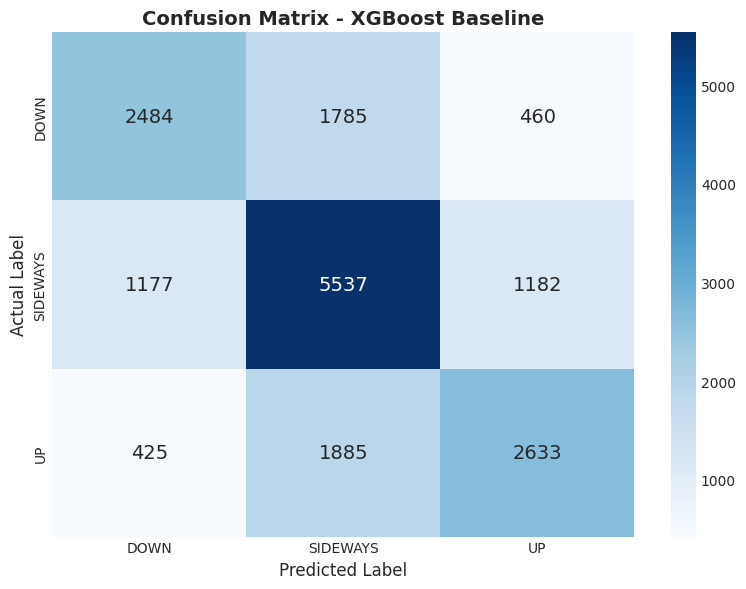


💡 CONFUSION MATRIX INTERPRETATION:
  - Diagonal values (correct): 10654 predictions
  - Off-diagonal (errors): 6914 predictions
  - Most common error: Actual=UP → Predicted=SIDEWAYS


In [14]:
# ==============================================================================
# CONFUSION MATRIX VISUALIZATION
# ==============================================================================
#
# WHY: Shows where the model makes mistakes.
#
# Reading the matrix:
# - Rows = Actual classes
# - Columns = Predicted classes
# - Diagonal = Correct predictions
# - Off-diagonal = Mistakes

fig, ax = plt.subplots(figsize=(8, 6))

cm = np.array(test_metrics['confusion_matrix'])
labels = ['DOWN', 'SIDEWAYS', 'UP']

# Create heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=ax,
            annot_kws={"size": 14})

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_title('Confusion Matrix - XGBoost Baseline', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('baseline_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Interpret the matrix
print("\n💡 CONFUSION MATRIX INTERPRETATION:")
print(f"  - Diagonal values (correct): {cm.diagonal().sum()} predictions")
print(f"  - Off-diagonal (errors): {cm.sum() - cm.diagonal().sum()} predictions")

# Find most common error
off_diag = cm.copy()
np.fill_diagonal(off_diag, 0)
max_error_idx = np.unravel_index(off_diag.argmax(), off_diag.shape)
print(f"  - Most common error: Actual={labels[max_error_idx[0]]} → Predicted={labels[max_error_idx[1]]}")

## 6. Feature Importance Analysis

**WHY ANALYZE FEATURE IMPORTANCE?**

- Understand what drives predictions
- Identify potentially useless features
- Guide future feature engineering
- Explain model to stakeholders

In [15]:
# ==============================================================================
# FEATURE IMPORTANCE VISUALIZATION
# ==============================================================================
#
# XGBoost calculates feature importance based on:
# - How often a feature is used in splits (gain)
# - How much it improves predictions (weight)

print("\n" + "="*60)
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Get feature importance DataFrame
fi = model.get_feature_importance()

print("\nTop 10 most important features:")
print(fi.head(10).to_string(index=False))


🔍 FEATURE IMPORTANCE ANALYSIS

📊 Top 20 Features:
            Feature  Importance
           WILLR_14    0.211415
             MOM_10    0.096058
          total_vol    0.063644
     BBP_20_2.0_2.0    0.053849
            NATR_14    0.052239
           sell_vol    0.048746
            buy_vol    0.043643
STOCHRSIk_14_14_3_3    0.037679
      STOCHh_14_3_3    0.035039
              ZS_30    0.024514
     BBB_20_2.0_2.0    0.022777
      MACDh_12_26_9    0.019766
                PVI    0.016586
          AROOND_14    0.014956
             RSI_14    0.014851
            ATRr_14    0.014252
             DMP_14    0.013333
          AROONU_14    0.013098
             DMN_14    0.012865
             VAR_30    0.010274

Top 10 most important features:
            Feature  Importance
           WILLR_14    0.211415
             MOM_10    0.096058
          total_vol    0.063644
     BBP_20_2.0_2.0    0.053849
            NATR_14    0.052239
           sell_vol    0.048746
            buy_vol 

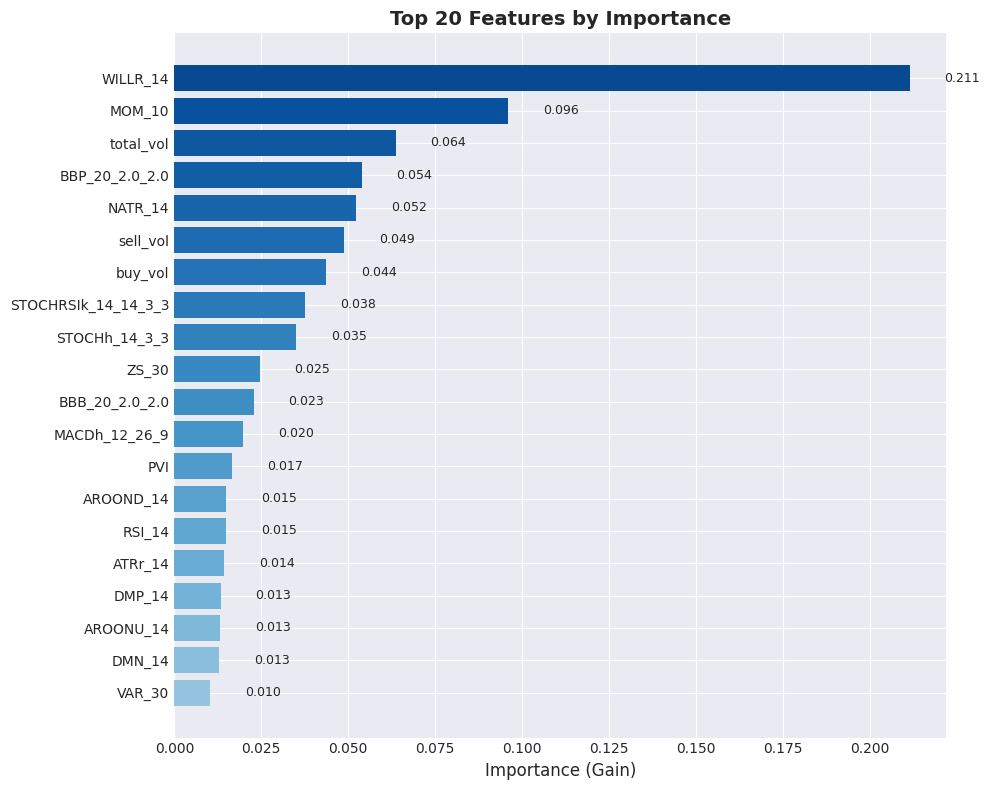


💡 INTERPRETATION:
  - Higher importance = feature is more useful for predictions
  - Momentum/Trend indicators often dominate
  - Low-importance features could be removed


In [16]:
# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))

top_20 = fi.head(20)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, len(top_20)))[::-1]

bars = ax.barh(range(len(top_20)), top_20['Importance'].values, color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'].values, fontsize=10)
ax.invert_yaxis()  # Most important at top
ax.set_xlabel('Importance (Gain)', fontsize=12)
ax.set_title('Top 20 Features by Importance', fontsize=14, fontweight='bold')

# Add value labels
for bar, imp in zip(bars, top_20['Importance'].values):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{imp:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('baseline_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETATION:")
print("  - Higher importance = feature is more useful for predictions")
print("  - Momentum/Trend indicators often dominate")
print("  - Low-importance features could be removed")

In [17]:
# ==============================================================================
# SAVE MODEL AND ARTIFACTS
# ==============================================================================
#
# WHY SAVE?
# - Reuse model for inference without retraining
# - Compare different model versions
# - Deploy to production

print("\n" + "="*60)
print("💾 SAVING MODEL AND ARTIFACTS")
print("="*60)

# Create output directory
Path('models_artifacts').mkdir(exist_ok=True)
Path('reports').mkdir(exist_ok=True)

# Save model
model.save('models_artifacts', name=f'xgb_baseline_h{HORIZON}')
print(f"✅ Model saved: models_artifacts/xgb_baseline_h{HORIZON}_model.joblib")

# Save feature importance
fi.to_csv(f'models_artifacts/feature_importance_h{HORIZON}.csv', index=False)
print(f"✅ Feature importance saved: models_artifacts/feature_importance_h{HORIZON}.csv")

# Save metrics
import json
with open(f'reports/baseline_metrics_h{HORIZON}.json', 'w') as f:
    json.dump({
        'accuracy': test_metrics['accuracy'],
        'f1_weighted': test_metrics['f1_weighted'],
        'f1_macro': test_metrics['f1_macro'],
        'best_params': best_params
    }, f, indent=2)
print(f"✅ Metrics saved: reports/baseline_metrics_h{HORIZON}.json")


💾 SAVING MODEL AND ARTIFACTS
✅ Model saved to models_artifacts
✅ Model saved: models_artifacts/xgb_baseline_h1_model.joblib
✅ Feature importance saved: models_artifacts/feature_importance_h1.csv
✅ Metrics saved: reports/baseline_metrics_h1.json


## 7. Summary

In [18]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("\n" + "="*60)
print("📋 BASELINE MODEL SUMMARY")
print("="*60)

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Oracle: sigma={SIGMA}, threshold={THRESHOLD}
• Horizon: {HORIZON} bar(s) ({HORIZON * 15} minutes)
• Training: up to {TRAIN_END}
• Testing: from {TEST_START}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Test Accuracy:  {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']:.1%})
• F1 Weighted:    {test_metrics['f1_weighted']:.4f}
• F1 Macro:       {test_metrics['f1_macro']:.4f}
• Random Baseline: 33.3%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔧 BEST HYPERPARAMETERS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
{chr(10).join(f'• {k}: {v}' for k, v in best_params.items())}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Model: models_artifacts/xgb_baseline_h{HORIZON}_model.joblib
• Feature Importance: models_artifacts/feature_importance_h{HORIZON}.csv
• Metrics: reports/baseline_metrics_h{HORIZON}.json
""")

print("="*60)
print("✅ BASELINE TRAINING COMPLETE!")
print("="*60)
print("\nNext step: Run 03_cnn_lstm.py to train the advanced model.")


📋 BASELINE MODEL SUMMARY

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
⚙️ CONFIGURATION
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Oracle: sigma=4, threshold=0.0002
• Horizon: 1 bar(s) (15 minutes)
• Training: up to 2025-06-30
• Testing: from 2025-07-01

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 RESULTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Test Accuracy:  0.6064 (60.6%)
• F1 Weighted:    0.6035
• F1 Macro:       0.5941
• Random Baseline: 33.3%

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔧 BEST HYPERPARAMETERS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• subsample: 0.6
• reg_lambda: 0.1
• reg_alpha: 1
• n_estimators: 200
• min_child_weight: 3
• max_depth: 2
• learning_rate: 0.03
• gamma: 0
• colsample_bytree: 0.8

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
💾 SAVED FILES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Model: models_artifacts/xgb_baseline_h1_mod